# Retail Visualization

In [1]:
import pandas as pd
import numpy as np

# Local libraries should automatically reload
%load_ext autoreload
%autoreload 1

SCHEMA = 'RETAIL'

### Read from input table

We read from the **RETAIL_CUST_VEC** table containing a 10 dimensional vector for each patient.

In [2]:
%aimport gpudb_df

# load input table
_table_df = gpudb_df.load_df('RETAIL_CUST_VEC')
_table_df.head()

Getting records from <RETAIL_CUST_VEC>.
Records Retrieved: (4372, 11)


,CUSTOMER_ID,U0,U1,U2,U3,U4,U5,U6,U7,U8,U9
0,12346,-0.002962,0.003276,-0.004209,0.004890,0.003855,0.002955,-0.000507,-0.000469,0.000187,-0.005176
1,12347,-0.218411,-0.118339,-0.133780,-0.006961,0.277335,-0.027150,0.148333,-0.023972,-0.242682,-0.109366
2,12348,-0.037311,-0.031022,0.017272,-0.046773,0.100410,-0.042978,0.095058,0.044239,0.106608,-0.064844
3,12349,-0.081221,-0.074629,-0.023124,-0.009394,0.064690,-0.025219,0.086057,0.047981,0.042952,-0.036295
4,12350,-0.014273,-0.009140,-0.003047,-0.031547,0.022964,-0.005284,0.037201,0.004301,0.021141,-0.014964


### Gaussian Mixture Clustering

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

http://scikit-learn.org/stable/modules/mixture.html#mixture

In [44]:
# number of clusters to find
CUST_CLUSTERS = 6

# numer of columns to keep (dimension n-1)
VECTOR_END_IDX = 6

# convert to numpty matrix
_table_np = _table_df.iloc[:,1:VECTOR_END_IDX].values.astype(np.float64)

print('Input customer vectors: ', _table_np.shape)

Input customer vectors:  (4372, 5)


In [57]:
from sklearn.mixture import GaussianMixture

_cust_mixture = GaussianMixture(
    n_components=CUST_CLUSTERS, 
    n_init=10, 
    random_state=1).fit(_table_np)

_cust_clusters = _cust_mixture.means_
_cust_labels = _cust_mixture.predict(_table_np)

print('GaussianMixture clusters: ', _cust_clusters.shape)
print('GaussianMixture labels: ', _cust_labels.shape)

GaussianMixture clusters:  (6, 5)
GaussianMixture labels:  (4372,)


### Calculate K-Means

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 

http://scikit-learn.org/stable/modules/clustering.html#k-means

Note: K-menas struggles to find centroids for higher dimensional data but can be more accurate then Gaussian Mixture when it works well.

In [58]:
#from sklearn.cluster import KMeans

# _cust_means = KMeans(n_clusters=CUST_CLUSTERS,
#                     verbose=False,
#                      max_iter=1000,
#                     random_state=0).fit(_table_np)

# _cust_clusters = _cust_means.cluster_centers_
# _cust_labels = _cust_means.labels_

# print('KMeans clusters: ', _cust_clusters.shape)
# print('KMeans labels: ', _cust_labels.shape)

### Create a combined dataframe of counts and means

In [59]:
# get counts of means
_labels_df = pd.DataFrame(_cust_labels, columns=['IDX'])
_counts_df = pd.DataFrame(_labels_df.groupby('IDX').size(), columns=['COUNT'])

# create a dataframe of centroids
_centroids_df = pd.DataFrame(_cust_clusters, 
                             columns=_table_df.columns[1:VECTOR_END_IDX],
                             index=_counts_df.index)

# create a combined dataframe
_means_df = pd.concat([_counts_df, _centroids_df], axis=1)
_means_df

,COUNT,U0,U1,U2,U3,U4
IDX,,,,,,
0,1322,-0.012421,-0.010287,-0.005687,-0.000419,-0.003508
1,324,-0.604541,-0.207032,0.289698,0.043718,-0.032457
2,1,-13.178332,11.585377,-3.866960,1.481475,1.169344
3,1094,-0.162661,-0.088603,0.019619,0.004643,-0.009511
4,3,-5.665859,-4.215140,-2.531204,-2.559036,0.307209
5,1628,-0.048952,-0.033124,-0.008899,-0.002810,-0.001615


### Save k-means table to Kinetica

In [60]:
%aimport gpudb_df
gpudb_df.save_df(_means_df, 'RETAIL_KMEANS', SCHEMA)

Dropping table: <RETAIL_KMEANS>
Creating table: <RETAIL_KMEANS>
Column 0: <IDX> (long)
Column 1: <COUNT> (long)
Column 2: <U0> (double)
Column 3: <U1> (double)
Column 4: <U2> (double)
Column 5: <U3> (double)
Column 6: <U4> (double)
Inserted rows into <RETAIL.RETAIL_KMEANS>: 6


### Generate labels for centroids

The labels of the t-SNE plot need to be determined manually from the drug ratings for each centriod. The below SQL will generate 4 approximations for each centroid.

In [62]:
%aimport gpudb_df
_cnxn = gpudb_df.get_odbc()

_sql = """
select top 4
    cv.IDX,
    iv.STOCK_CODE,
    cv.COUNT,
    rp.DESCRIPTION,
    (cv.U0 * iv.V0)
    + (cv.U1 * iv.V1) 
    + (cv.U2 * iv.V2) 
    + (cv.U3 * iv.V3) 
    + (cv.U4 * iv.V4)
    as ITEM_RATING
from RETAIL_KMEANS as cv, RETAIL_ITEM_VEC as iv
join RETAIL_PROD rp
    on rp.STOCK_CODE = iv.STOCK_CODE
where cv.idx = {}
order by ITEM_RATING desc
"""

_final_df = pd.DataFrame()

for _idx in _means_df.index.values:
    _new_sql = _sql.format(_idx)
    print('Calculating index: {}'.format(_idx))
    _rows_df = pd.read_sql(_new_sql, _cnxn)
    _final_df = _final_df.append(_rows_df)

_cnxn.close()

_final_df = _final_df.set_index(['IDX','STOCK_CODE'])
_final_df

Connected to GPUdb ODBC Server (6.1.0.9.20180315110536)
Calculating index: 0
Calculating index: 1
Calculating index: 2
Calculating index: 3
Calculating index: 4
Calculating index: 5


COUNT                         DESCRIPTION  ITEM_RATING
IDX STOCK_CODE                                                        
0   22423        1322            REGENCY CAKESTAND 3 TIER     0.064984
    85123A       1322  WHITE HANGING HEART T-LIGHT HOLDER     0.063087
    C2           1322                            CARRIAGE     0.047248
    22699        1322     ROSES REGENCY TEACUP AND SAUCER     0.043068
1   85099B        324             JUMBO BAG RED RETROSPOT     2.793361
    20725         324                LUNCH BAG RED SPOTTY     2.292680
    85123A        324  WHITE HANGING HEART T-LIGHT HOLDER     2.201357
    20727         324             LUNCH BAG  BLACK SKULL.     1.926298
2   79321           1                       CHILLI LIGHTS    65.361154
    21975           1      PACK OF 60 DINOSAUR CAKE CASES    52.956748
    21927           1     BLUE/CREAM STRIPE CUSHION COVER    52.571649
    22467           1                   GUMBALL COAT RACK    50.175487
3   22423        1094            REGENCY CAKESTAND 3 TIER     0.658263
    85123A       1094  WHITE HANGING HEART T-LIGHT HOLDER     0.647248
    85099B       1094             JUMBO BAG RED RETROSPOT     0.536112
    22197        1094                SMALL POPCORN HOLDER     0.486515
4   22423           3            REGENCY CAKESTAND 3 TIER    25.861216
    22197           3                SMALL POPCORN HOLDER    19.246853
    85123A          3  WHITE HANGING HEART T-LIGHT HOLDER    18.661348
    C2              3                            CARRIAGE    17.845359
5   22423        1628            REGENCY CAKESTAND 3 TIER     0.231864
    85123A       1628  WHITE HANGING HEART T-LIGHT HOLDER     0.197623
    C2           1628                            CARRIAGE     0.157185
    22197        1628                SMALL POPCORN HOLDER     0.157129

### Manually entered labels for the clusters

(These need to be updated after running on a new data set)

In [63]:
_cbar_labels = [ 
    'Generic "other"',
    'LUNCH BAG',
    'CHILLI LIGHTS',
    'T-LIGHT HOLDER',
    'REGENCY CAKESTAND',
    'REGENCY CAKESTAND' ]

### 2D t-SNE Visualization

t-distributed Stochastic Neighbor Embedding

http://scikit-learn.org/stable/modules/manifold.html#t-sne

In [10]:
from sklearn.manifold import TSNE

# This algorithm is slow so we only use the first N points.
TSNE_POINTS = 1000

tsne_2d = TSNE(
    n_components=2, 
    verbose=1, 
    #perplexity=80, 
    #n_iter=600, 
    random_state=0
)

tsne_2d_results = tsne_2d.fit_transform(_table_np[:TSNE_POINTS])
print('Done', tsne_2d_results.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.006543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.690956
[t-SNE] Error after 1000 iterations: 0.575046
Done (1000, 2)


### Plot t-SNE results with cluster labels

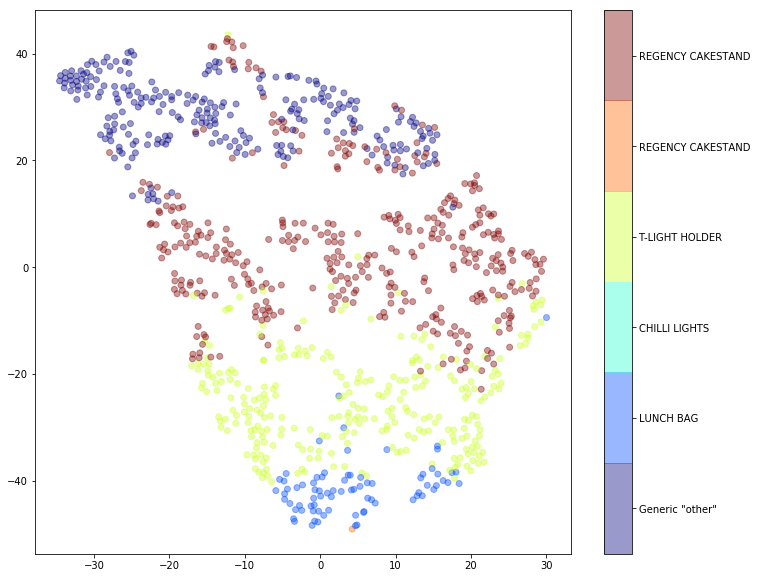

In [64]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,10))
sc = plt.scatter(
    x=tsne_2d_results[:,1],
    y=tsne_2d_results[:,0], 
    c=_cust_labels[:TSNE_POINTS], 
    alpha=0.4, 
    cmap=plt.cm.get_cmap("jet", CUST_CLUSTERS)
)
plt.clim(-0.5, CUST_CLUSTERS - 0.5)
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels(_cbar_labels)
plt.show()

### 3D t-SNE Visualization

In [12]:
from sklearn.manifold import TSNE
TSNE_3D_POINTS = 2000

tsne_3d = TSNE(
    n_components=3, 
    verbose=1, 
    #perplexity=80, 
    #n_iter=600, 
    random_state=0
)
tsne_3d_results = tsne_3d.fit_transform(_table_np[:TSNE_POINTS])
print('Done', tsne_3d_results.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.006543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.028450
[t-SNE] Error after 1000 iterations: 0.458099
Done (1000, 3)


In [65]:
import plotly.plotly as py
import plotly.graph_objs as go

scatter_3d = go.Scatter3d(
    x=tsne_3d_results[:,0],
    y=tsne_3d_results[:,1],
    z=tsne_3d_results[:,2],
    mode='markers',
    marker=dict(
        size=4,
        color=_cust_labels[:TSNE_3D_POINTS],
        colorscale='Viridis',
        opacity=0.5,
        showscale=True,
        colorbar=dict( 
            ticks='outside'
        )
    )
)

scatter_fig = go.Figure(
    data=[scatter_3d], 
    layout=go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
)

py.iplot(scatter_fig, filename='svd-tsne-3d')